# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from io import StringIO
import requests

import math
from tsad.evaluating.evaluating import evaluating #F1

import numpy as np
from itertools import chain # list of list to one bit list
from collections import namedtuple 

from scipy.signal import butter, filtfilt
from optcutfreq import optcutfreq
from detecta import detect_cusum #CUMSUM
from scipy.signal import savgol_filter

import sys
sys.path.append(r'/home/gishb/PycharmProjects/Fedot.Industrial') #SST
from core.operation.transformation.WindowSelection import WindowSizeSelection

# Dataset

In [2]:
def sinusoid_ts(size, amount_cp):
    ts, ts_cp, counter, l_ = [],[], 1, size // amount_cp
    while counter != amount_cp + 1:
        temp_ = np.random.randint(1,10)
        for i in range(0,l_):
            ts.append(math.sin(i)*temp_*counter + np.random.ranf())
        for i in range(0, l_-1):
            ts_cp.append(0)
        ts_cp.append(1)
        counter += 1
    ts_cp[-1] = 0
    return ts, ts_cp

In [3]:
def df_expirement():
    url = "https://storage.yandexcloud.net/cloud-files-public/dataframe.csv" 
    df = pd.read_csv(StringIO(requests.get(url).content.decode('utf-8')), sep='|')
    return df

In [4]:
df_test = df_expirement()
df_columns = df_test.columns 
first_label_list = df_test[df_columns[0]].unique() 
df_aa564g = df_test[df_test[df_columns[0]] == first_label_list[0]]
df_aa564g_first = df_aa564g.drop(axis=1, labels=(df_aa564g.columns[0])) \
    .drop(axis=1, labels=(df_aa564g.columns[1]))[['uR/h', 'unitless']].reset_index(drop=True)
df_test = df_aa564g_first.loc[df_aa564g_first['unitless'] >= 0]\
            .loc[df_aa564g_first['uR/h'] >= 0].reset_index(drop=True)

df_test['change_points'] = [1 if df_test['unitless'][i] !=  df_test['unitless'][i+1] else 0 for i in range(len(df_test)-1)] + [0]
df_test['time'] = np.arange(0, len(df_test)*1, 1).astype('datetime64[s]')
df_test = df_test.set_index('time')

# Breef look at data

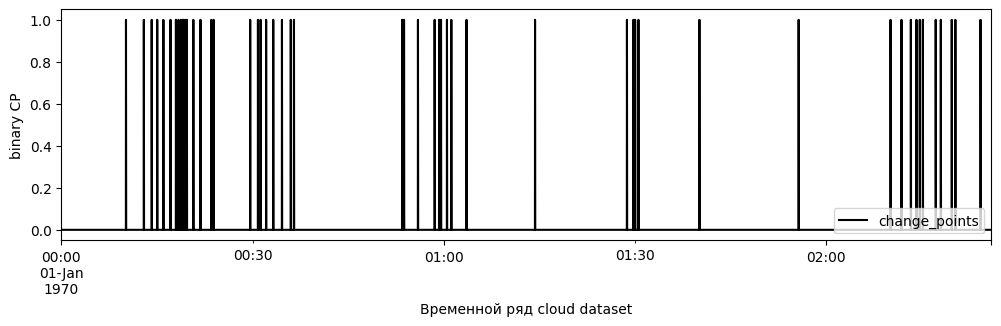

 Number CP: 52
 len data: 8754


In [5]:
df_test.change_points.plot(figsize=(12,3), color='black')
plt.legend(loc="lower right",)
plt.xlabel('Временной ряд cloud dataset')
plt.ylabel('binary CP')
plt.show()
print(f' Number CP: {df_test[df_test["change_points"] == 1].count()[0]}')
print(f' len data: {df_test.count()[0]}')

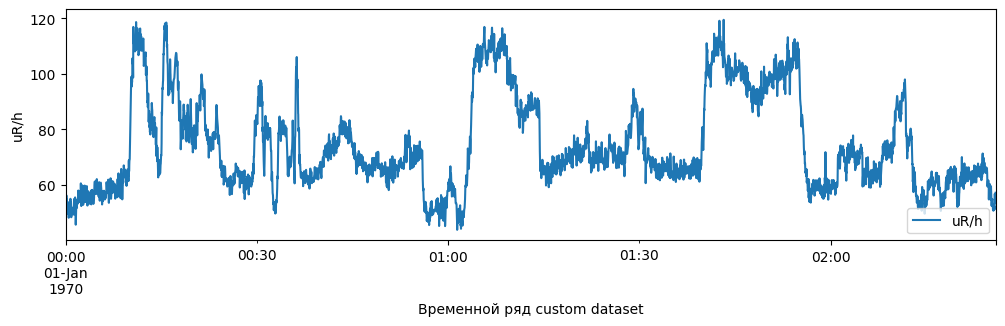

In [6]:
df_test['uR/h'].plot(figsize=(12,3))
plt.legend(loc="lower right")
plt.xlabel('Временной ряд custom dataset')
plt.ylabel('uR/h')
plt.show()

# Define filters & cumsumm & TSAD metric

In [7]:
def filter_butterworth(ts, freq): #list, int(1)
    '''
        Just butterworh filter
    '''
    fc_opt = optcutfreq(ts, freq=freq, show=False)

    C = 0.802 # for dual pass; C = (2**(1/npasses) - 1)**0.25
    b, a = butter(2, (fc_opt/C)/(freq/2))
    dispf = filtfilt(b, a, ts)
    aaccBW =  np.diff(dispf, 2)*fc_opt*fc_opt
    return aaccBW

def cumsum(x):
    '''
        Just CUMSUM filter
    '''
    ending, start, alarm, cumsum = detect_cusum(x, np.mean(x)+3*np.std(x), np.std(x), True, False)
    return ending, start, alarm, cumsum 

def filter_Savgol(x, window_length):
    '''
        Savitzky-Golay filter from scipy
    '''
    aaccSG = savgol_filter(x, window_length, 3, mode='nearest')
    return np.array(aaccSG)

def tsad_average(predicted_list, original_list):
    averate_time, missed_cp, FPs, true_anomalies = evaluating(original_list, predicted_list, metric='average_time', numenta_time='30 sec', verbose=False)
    TP = true_anomalies - missed_cp
    precision = TP/(TP+FPs)
    recall = TP/(TP+missed_cp)
    if precision == 0 or recall ==0:
        F1 = 0
    else:
        F1 = 2*precision*recall/(precision+recall)
    return {'Time_Delta': averate_time, 'Missed_CP': missed_cp, 'FPs': FPs, 'True_Anomalies_Count': true_anomalies, 'precision':precision, 'recall':recall,'F1':F1}

def tsad_nab(predicted_list, original_list):
    nab = evaluating(original_list, predicted_list, metric='nab', numenta_time='30 sec', verbose=False)
    return nab

def normalization_linear(x):
    return (x-min(x))/(max(x)-min(x))

# Workflow: 1 stage - apply filter 

In [8]:
# time_series = np.array(df_test['ts'])
time_series = normalization_linear(np.array(df_test['uR/h']))
# ts_butterworth = filter_butterworth(time_series, 1)
ts_savgol = filter_Savgol(normalization_linear(time_series), 60)
print(f'time series.shape: {time_series.shape}')

time series.shape: (8754,)


In [9]:
# #plt.plot(ts_savgol, figsize=(12,3))
# plt.figure(figsize=(12,3))
# plt.plot(ts_savgol)
# plt.legend(loc="lower right")
# plt.xlabel('Временной ряд сглаженный фильтром Savgol')
# plt.ylabel('б.в.')
# plt.show()

# Workflow: 2 stage - find window_size

In [51]:
# window_length = WindowSizeSelection(time_series = list(ts_savgol[:int(len(ts_savgol)/2)]),
#                                        wss_algorithm = 'highest_autocorrelation').runner_wss()[0]
window_length = WindowSizeSelection(time_series = list(time_series),
                                       wss_algorithm = 'highest_autocorrelation').runner_wss()[0]

In [52]:
print(window_length)

40


# Workflow: 3 stage define Kalman Filter model

In [12]:
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

In [13]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

def list_measured_function(window_size, ts):
    list_measured_pos = []
    for i in range(0, len(ts), window_size):
        temp = list(ts[i:i+window_size])
        mean_ts, var_ts = np.mean(temp), np.var(temp)
        list_measured_pos.append(gaussian(mean_ts, var_ts))
    return list_measured_pos

def make_one_step_prediction(list_measured_pos, g=gaussian(1, .5**2), window=10):
    list_prediction, predictions_mean, predictions_var = [], [], []
    for i in range(1,len(list_measured_pos)+1):
        prior, likelihood = predict(list_measured_pos[i-1], g), list_measured_pos[i-1]
        x = update(prior, likelihood)
      #  predictions_x.extend(np.random.normal(loc=x.mean, scale=x.var, size=window))
        predictions_mean.extend(np.full(window, x.mean))
        predictions_var.extend(np.full(window, x.var))
        list_prediction.append(x)
#     print()
#     print('final estimate:        {:10.3f}'.format(list_prediction[-1].mean))
#     print('actual final position: {:10.3f}'.format(list_measured_pos[-1].mean))
    return list_prediction, predictions_mean, predictions_var

# Workflow: 4 stage apply Kalman Filter

In [14]:
list_measured_pos = list_measured_function(window_size= int(window_length), ts = time_series)
# list_measured_pos = list_measured_function(window_size= int(window_length/3.14), ts = time_series)

In [15]:
list_prediction, list_x_mean, list_x_var = make_one_step_prediction(list_measured_pos, g=gaussian(1, .18**2), window = int(window_length))
# list_prediction, list_x_mean, list_x_var = make_one_step_prediction(list_measured_pos, g=gaussian(1, .18**2), window = int(window_length/3.14))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


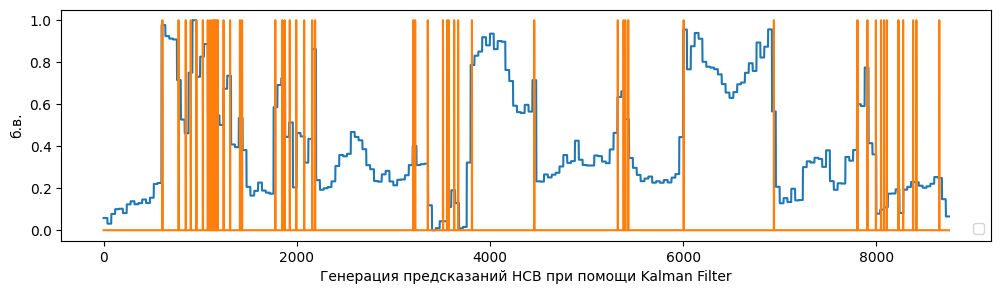

In [16]:
plt.figure(figsize=(12,3))
plt.plot(normalization_linear(list_x_mean[:len(df_test)]))
plt.plot(list(df_test['change_points']))
plt.legend(loc="lower right")
plt.xlabel('Генерация предсказаний НСВ при помощи Kalman Filter')
plt.ylabel('б.в.')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


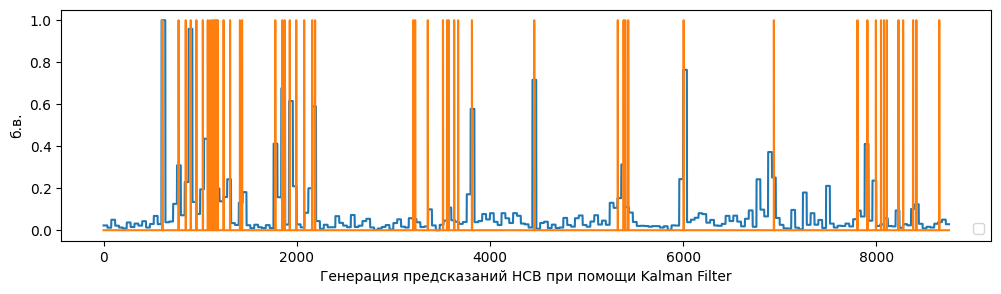

In [17]:
plt.figure(figsize=(12,3))
plt.plot(normalization_linear(list_x_var[:len(df_test)]))
plt.plot(list(df_test['change_points']))
plt.legend(loc="lower right")
plt.xlabel('Генерация предсказаний НСВ при помощи Kalman Filter')
plt.ylabel('б.в.')
plt.show()

# Workflow: 5 stage find CPs

In [18]:
list_x_var_norm = list(normalization_linear(list_x_var[:len(df_test)])) + [0]

In [19]:
var_diff_list = [abs(list_x_var_norm[i] - list_x_var_norm[i+1]) for i in range(len(df_test)) if list_x_var_norm[i] != list_x_var_norm[i+1]]
mean_var_diff_ = np.mean(var_diff_list)
std_var_diff_ = np.std(var_diff_list)

In [20]:
print(mean_var_diff_)
print(std_var_diff_)

0.09599569028228659
0.17390196634401234


In [21]:
list_x_mean_norm = normalization_linear(list_x_mean)
mean_diff_list= [abs(list_x_mean_norm[i] - list_x_mean_norm[i+1]) for i in range(len(df_test)) if list_x_mean_norm[i] != list_x_mean_norm[i+1]]
mean_mean_diff_ = np.mean(mean_diff_list)
std_mean_diff_ = np.std(mean_diff_list)

In [22]:
print(mean_mean_diff_)
print(std_mean_diff_)

0.08045758629136154
0.11436295313041553


In [23]:
predicted_cp = []
for i in range(len(df_test)):
    mean_current = list_x_mean_norm[i]
    var_current = list_x_var_norm[i]
    mean_next = list_x_mean_norm[i+1]
    var_next = list_x_var_norm[i+1]
    if abs(mean_current - mean_next) > mean_mean_diff_ + std_mean_diff_ or abs(var_current - var_next) > mean_var_diff_ + std_var_diff_:
        predicted_cp.append(1)
    else:
        predicted_cp.append(0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


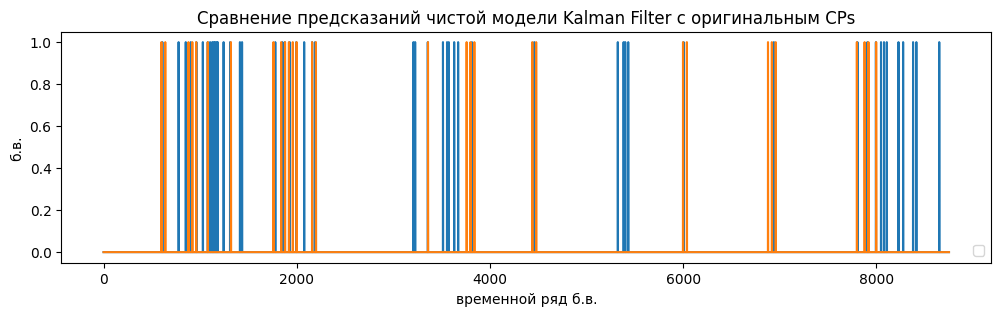

In [24]:
plt.figure(figsize=(12,3))
plt.plot(list(df_test['change_points']))
plt.plot(predicted_cp)
plt.legend(loc="lower right")
plt.title('Сравнение предсказаний чистой модели Kalman Filter с оригинальным CPs')
plt.xlabel('временной ряд б.в.')
plt.ylabel('б.в.')
plt.show()

# Workflow: 6 stage apply queue filter

In [25]:
def queue(queue_window=10, time_series=None):
    queue = [0]*queue_window
    filtered_score = []
    for i in range(len(time_series)):
        value = time_series[i]
        if max(queue) != 0: #Вариант при котором CPs уже в очереди
            filtered_score.append(0)
            queue.pop(0)
            queue.append(0)
        else: # В очереди нет CPs
            filtered_score.append(value)
            queue.pop(0)
            queue.append(value)
    return filtered_score

In [44]:
Kalman_queue_CPs = queue(queue_window=window_length, time_series=predicted_cp)
df_test['Kalman_queue_CPs'] = Kalman_queue_CPs

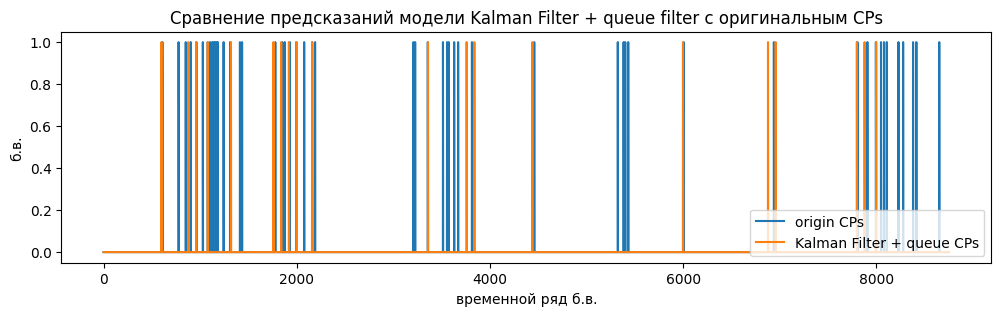

In [45]:
plt.figure(figsize=(12,3))
plt.plot(list(df_test['change_points']), label='origin CPs')
plt.plot(Kalman_queue_CPs, label='Kalman Filter + queue CPs')
plt.legend(loc="lower right")
plt.title('Сравнение предсказаний модели Kalman Filter + queue filter с оригинальным CPs')
plt.xlabel('временной ряд б.в.')
plt.ylabel('б.в.')
plt.show()

# Workflow 8: create report

In [46]:
def create_report(experiment_results: dict):
    experiment_df = pd.DataFrame.from_dict(experiment_results, orient='index')
    experiment_df = experiment_df.fillna(0)
    return experiment_df

In [47]:
%%capture --no-display
tsad_average_results = tsad_average(df_test.Kalman_queue_CPs, df_test.change_points)

In [48]:
%%capture --no-display
tsad_nab_results = tsad_nab(df_test.Kalman_queue_CPs, df_test.change_points)

In [49]:
tsad_nab_results.update(tsad_average_results)
create_report(tsad_nab_results)

,0
Standart,16.03
LowFP,14.38
LowFN,19.02
Time_Delta,0 days 00:00:12.538461538
Missed_CP,39
FPs,8
True_Anomalies_Count,52
precision,0.619048
recall,0.25
F1,0.356164
